### Methanol Synthesis through CO2 Hydrogenation on Cu(211)

Using the following reaction for the hydrogenation of Methanol

$CO_2 + 3H_2 \longrightarrow CH_3OH + H_2O$

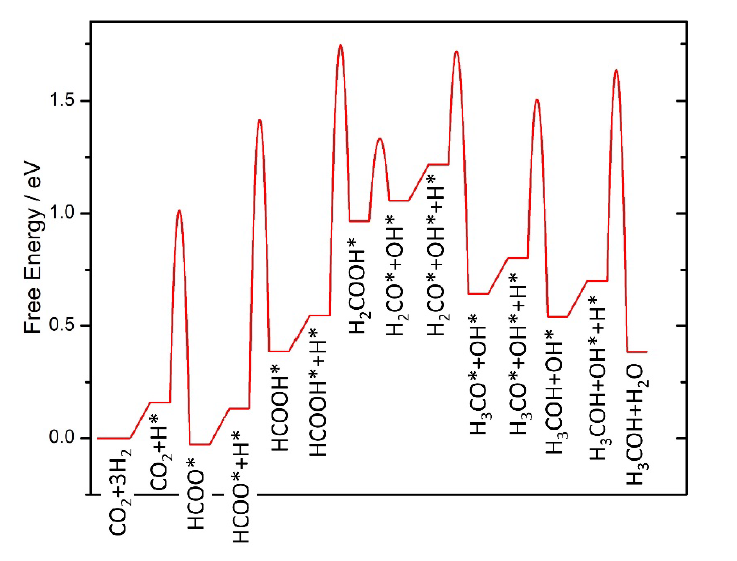

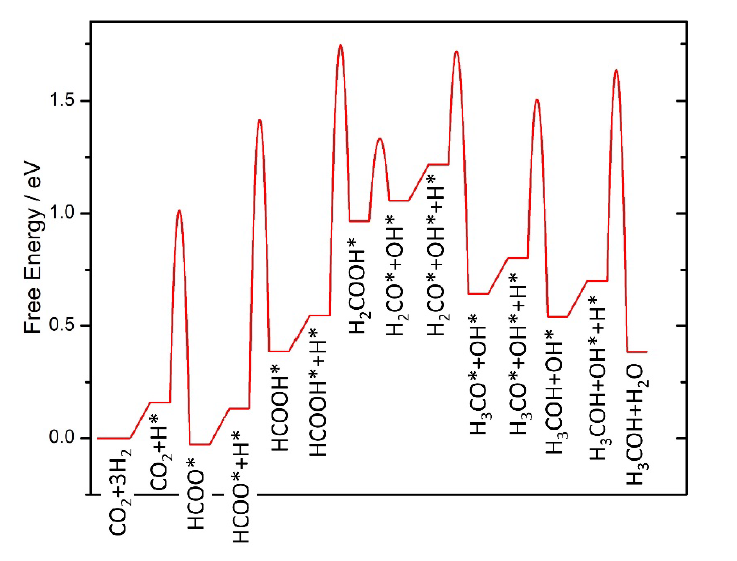

In [1]:
from IPython.display import Image
Image(filename='C:/Users/sk_ac/Box/siddarta/projects/DRC/Meth_hydrog_co2.PNG')
# Hope you can find this image on Box. This path is specific to my system 

As per the PES diagram provided by Dr. Campbell, the reactions can be written as follows: 

This reaction can be split into: 

R1:  $H_2 + * \longrightarrow 2H*$<br>
R2:  $CO_2 + H* \longrightarrow HCOO*$<br>
R3:  $HCOO* + H* \longrightarrow HCOOH* + *$<br>
R4:  $HCOOH* + H* \longrightarrow H_2COOH* + *$<br>
R5:  $H_2COOH* \longrightarrow H_2CO* + OH*$<br>
R6:  $H_2CO* + H* \longrightarrow H_3CO* + *$<br>
R7:  $H_3CO* + H* \longrightarrow H_3COH + 2*$<br>
R8:  $OH* + H* \longrightarrow  H_2O + 2*$<br>

So there would be mole balances for the following species: 
$H*, HCOO*, HCOOH*, H_2COOH*, H_2CO*, H_3CO*, H_3COH, OH*$

Considering the operating conditions as mentioned in the paper: 

$T = 450$ K<br>
$p_{H_2} =  22.5$ bar <br>
$p_{CO_2} = 7.5$ bar <br>

I considered the pressure of the products - Methanol ($CH_3OH$) and Water ($H_2O$) to be minimal:

$p_{CH_3OH} = 0$ bar <br>
$p_{H_2O} = 0$ bar

In [1]:
import autograd.numpy as np
from autograd.scipy.integrate import odeint
from autograd import elementwise_grad, grad, jacobian
from autograd.builtins import tuple
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The different intermediate and transition states are listed along with the expected DRCs and coverages:

|**Transition States**  | **Expected DRC**      | 
|-----------------------|-----------------------|
|$H-COO$ (TS2)          |          0.000        |   
|$HCOO-H$ (TS3)         |          0.000        | 
|$H-HCOOH$ (TS4)        |          0.999        | 
|$H_2CO-OH$ (TS5)       |          0.000        |
|$H-OCH_2$ (TS6)        |          0.000        |
|$H-OCH_3$ (TS7)        |          0.000        |
|$H-OH$ (TS8)           |          0.000        |

|**Intermediate States**| **Expected DRC**      |**Expected Coverage**| 
|-----------------------|-----------------------|------------|
|$H*$          |          -0.002        |   0.001
|$HCOO*$         |          -1.969        | 0.984
|$HCOOH*$       |          0.000        | 0.000
|$H_2COOH*$       |          0.000        | 0.000
|$H_2CO*$        |          0.000        | 0.000
|$H_3CO*$        |          0.000        | 0.000
|$OH*$           |          0.000        | 0.000
|$*$           |          -        |  0.015


Based on the reaction formulated, there would be a total of 8 mole balances for the intermediates:

$\frac{d\theta_{H*}}{dt} = k_1 \theta_{H*} - k_2\theta_{HCOO*} - k_3\theta_{HCOOH*}\theta_{H*} - k_4\theta_{HCOOH*}\theta_{H*} - k_6\theta_{H_2CO*}\theta_{H*} - k_7 \theta_{H_3CO*}\theta_{H*} - k_8 \theta_{OH*} \theta_{H*}$

$\frac{d\theta_{COO*}}{dt} = k_2p_{CO_2}\theta_{H*} - k_3\theta_{HCOOH*}\theta_{H*}$

$\frac{d\theta_{HCOOH*}}{dt} = k_3\theta_{H*}\theta_{HCOO*} - k_4\theta_{HCOOH*}\theta_{H*}$

$\frac{d\theta_{H_2COOH*}}{dt} = k_4\theta_{HCOOH*}\theta_{H*} - k_5\theta_{H_2COOH*}$

$\frac{d\theta_{H_2CO*}}{dt} = k_5\theta_{H_2COOH*} - k_6\theta_{H_2CO*}\theta_{H*}$

$\frac{d\theta_{H_3CO*}}{dt} = k_6\theta_{H_2CO*}\theta_{H*} - k_7\theta_{H_3CO*}\theta_{H*}$

$\frac{d\theta_{OH*}}{dt} = k_5\theta_{H_2COOH} - k_8 \theta_{OH*}\theta_{H*}$

The last one would be the site balance (for the coverages):

$0 = 1 - \theta_{H*} - \theta_{HCOO*} - \theta_{HCOOH*} - \theta_{H_2COOH*} - \theta_{H_2COOH*} - \theta_{H_2CO*} - \theta_{H_3CO} - \theta_{OH*} - \theta_*$

The rate constants are defined: 

$k_1 = f(G_{H*})$
 
$k_2 = f(G_{TS_1} - G_{H*})$

$k_3 = f(G_{TS_2} - (G_{HCOO*} + G_{H*}))$

$k_4 = f(G_{TS_3} - (G_{HCOOH*} + G_{H*}))$

$k_5 = f(G_{TS_4} - G_{H_2COOH*})$

$k_6 = f(G_{TS_5} - (G_{H_2CO*} + G_{H*} + G_{OH*}))$

$k_7 = f(G_{TS_6} - (G_{H_3CO*} + G_{H*} + G_{OH*}))$

$k_8 = f(G_{TS_7} - (G_{H_3COH*} + G_{H*} + G_{OH*}))$

In [2]:
from scipy.optimize import fsolve

kb = 1.381e-23
h = 6.626e-34
R = 8.314
T = 450 #K
Pt = 30 # bar
pH2 = 22.5 #bar
pCO2 = 7.5 #bar
pMETH = 0 #bar
pH2O = 0 #bar

def kd(dGi):
    return (kb*T/h)*np.exp(-dGi/R/T)

def func_k(G):
    
    Gts2, Gts3, Gts4, Gts5, Gts6, Gts7, Gts8, GHs, GHCOOs, GHCOOHs, \
    GH2COOHs, GH2COs, GH3COs, GOHs, GH3COH= G
    k1 = kd(2*GHs) 
    k2 = kd(Gts2 - GHs)
    k3 = kd(Gts3 - (GHCOOs + GHs))
    k4 = kd(Gts4 - (GHCOOHs + GHs))
    k5 = kd(Gts5 - GH2COOHs)
    k6 = kd(Gts6 - (GH2COs + GHs ))
    k7 = kd(Gts7 - (GH3COs + GHs ))
    k8 = kd(Gts8 - (GH3COH + GHs + GOHs))
    
    k_1 = kd(0) 
    k_2 = kd(Gts2 - GHCOOs)
    k_3 = kd(Gts3 - GHCOOHs)
    k_4 = kd(Gts4 - GH2COOHs)
    k_5 = kd(Gts5 - (GH2COs + GOHs))
    k_6 = kd(Gts6 - (GH3COs ))
    k_7 = kd(Gts7 - (GH3COH ))
    k_8 = kd(Gts8 - GH3COH)
    return np.array([k1,k2,k3,k4,k5,k6,k7,k8,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8])

def rsys(THETA, G):
    k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8 = func_k(G)
    T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S = THETA
    
    # R1 : H2 + 2* --> 2H*
    r1 = k1 * pH2 * T_S**2
    r_1 = k_1 * T_H**2
    
    # R2: CO2 + H* --> HCOO*
    r2 = k2 * pCO2 * T_H
    r_2 = k_2 * T_HCOO 
    
    # R3: HCOO* + H* --> HCOOH* + *
    r3 = k3 * T_HCOO * T_H
    r_3 = k_3 * T_HCOOH * T_S
    
    # R4: HCOOH* + H* --> H2COOH + *
    r4 = k4 * T_HCOOH * T_H
    r_4 = k_4 * T_H2COOH * T_S
    
    # R5: H2COOH* + * --> H2CO* + OH*
    r5 = k5 * T_H2COOH * T_S
    r_5 = k_5 * T_H2CO * T_OH
    
    # R6: H2CO* + H* --> H3CO* + * 
    r6 = k6 * T_H2CO * T_H
    r_6 = k_6 * T_H3CO * T_S
    
    # R7: H3CO* + H* --> H3COH + 2*
    r7 = k7 * T_H3CO * T_H
    r_7 = k_7 * pMETH * T_S**2
    
    # R8: OH* + H* --> H20 + 2*
    r8 = k8 * T_OH * T_H
    r_8 = k_8 * pH2O * T_S**2
    
    #balance on H*
    z1 = (r1 - r_1) + (-r2 + r_2) + (-r3 + r_3) + (-r4 + r_4) + (-r6 + r_6) + (-r7 + r_7) + (-r8 + r_8)
    
    #balance on HCOO*
    z2 = (r2 - r_2) + (-r3 + r_3)
    
    #balance on HCOOH*
    z3 = (r3 - r_3) + (-r4 + r_4)
    
    #balance on H2COOH*
    z4 = (r4 - r_4) + (-r5 + r_5)
    
    #balance on H2CO*
    z5 = (r5 - r_5) + (-r6 + r_6)
    
    #balance on H3CO*
    z6 = (r6 - r_6) + (-r7 + r_7)
    
    #balance on OH*
    z7 = (r5 - r_5) + (-r8 + r_8)
    
#     print('1:',r1 - r_1)
#     print('2',r2 - r_2)
#     print('3', r3 - r_3)
    
    z8 = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH - T_S
    
    return np.array([z1, z2, z3, z4, z5, z6, z7, z8])

#            Gts2   Gts3  Gts4  Gts5  Gts6  Gts7  Gts8  GHs   GHCOOs GHCOOHs GH2COOHs GH2COs  GH3COs GOHs, GH3COH
G = np.array([1.01, 1.41, 1.73, 1.33, 1.53, 1.35, 1.25, 0.16, -0.03, 0.39,   0.97,    0.90,   0.49,  0.16,  0.29]) # made a set using the excel sheet 
G = G*100000
print(G)
[T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S]\
= fsolve(rsys, [0.001, 0.984, 0.00000, 0.00000, 0.00000, 0.00000, 0.000000, 0.015], args = (G,))

k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8 = func_k(G)

print(sum([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S]))
# Theta
# print(Theta)
r = k7 * T_H3CO * T_H
print(T_H3CO, T_H)

print(f'The coverages are: {T_H:1.4f},  {T_HCOO:1.4f},  {T_HCOOH:1.4f},  {T_H2COOH:1.4f},  {T_H2CO:1.4f},  {T_H3CO:1.4f},  {T_OH:1.4f},  {T_S:1.4f}')
print('                      T_H,   T_HCOO,  T_HCOOH,  T_H2COOH, T_H2CO,  T_H3CO,   T_OH,   T_S')

# print(k2/k_2)
# print(k1/k_1)

print(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8)

[101000. 141000. 173000. 133000. 153000. 135000. 125000.  16000.  -3000.
  39000.  97000.  90000.  49000.  16000.  29000.]
1.0
1.6693994296047635e-10 0.000819544477128155
The coverages are: 0.0008,  0.9867,  0.0001,  0.0000,  0.0000,  0.0000,  0.0000,  0.0124
                      T_H,   T_HCOO,  T_HCOOH,  T_H2COOH, T_H2CO,  T_H3CO,   T_OH,   T_S
1809494701.7832398 1274.2519227523276 0.012994661796494479 0.18818139447326918 621201699.4899431 32835207.376379773 70221.94428460047 349108.0561288758 9378961666163.598 7.938036008527302 13.54800676820316 14124.914543046734 6885938928.260363 7.938036008527302 4.651046958476922 67.3538500742634


In [202]:
r1 = k1 * pH2 * T_S**2
r_1 = k_1 * T_H**2

# R2: CO2 + H* --> HCOO*
r2 = k2 * pCO2 * T_H
r_2 = k_2 * T_HCOO 

# R3: HCOO* + H* --> HCOOH* + *
r3 = k3 * T_HCOO * T_H
r_3 = k_3 * T_HCOOH * T_S

# R4: HCOOH* + H* --> H2COOH + *
r4 = k4 * T_HCOOH * T_H
r_4 = k_4 * T_H2COOH * T_S

# R5: H2COOH* + * --> H2CO* + OH*
r5 = k5 * T_H2COOH * T_S
r_5 = k_5 * T_H2CO * T_OH

# R6: H2CO* + H* --> H3CO* + * 
r6 = k6 * T_H2CO * T_H
r_6 = k_6 * T_H3CO * T_S

# R7: H3CO* + H* --> H3COH + 2*
r7 = k7 * T_H3CO * T_H
r_7 = k_7 * pMETH * T_S**2

# R8: OH* + H* --> H20 + 2*
r8 = k8 * T_OH * T_H
r_8 = k_8 * pH2O * T_S**2

print(r1 - r_1)
print(r2 - r_2)
print(r3 - r_3)
print(r4 - r_4)
print(r5 - r_5)
print(r6 - r_6)
print(r7 - r_7)
print(r8 - r_8)



1.392456948165141e-10
-1.6130895447510896e-17
2.028532391905189e-10
-3.480209261146126e-10
3.5176002490138093e-10
1.4517935720153315e-08
-1.9200448502367172e-13
2.25340158510104e-34


These values might not match the expected results but, $\theta_{HCOO}$ has the highest coverage as expected. 

Using the fsolve method that was implemented for the L-H reaction mechanism, 
The rate of the derivative $\frac{dr}{dG}$ is calculated by using the rate law for the fourth reaction (R4): 

$r = k_4 \theta_{HCOO*} \theta_{H*}$

So, inorder to calculate $\frac{dr}{dG}$ it would become: 

$\theta_{HCOO*}(k_4 \frac{d\theta_{H*}}{dG} + \theta_{H*} \frac{dk_4}{dG}) + k_4 \frac{\theta_{HCOO}}{dG} \theta_H$

Where each of the derivates above are calculated by using linear algebra.

In [5]:
from autograd import jacobian

dsysdtheta = jacobian(rsys, 0)
dsysdG = jacobian(rsys, 1)

dSdth = dsysdtheta(np.array([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S]), np.array(G))
dSdG = dsysdG(np.array([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S]), np.array(G))

dthdG = -np.linalg.inv(dSdth) @ dSdG

t_H, t_HCOO, t_HCOOH, t_H2COOH, t_H2CO, t_H3CO, t_OH, t_S = np.arange(8)
gts1, gts2, gts3, gts4, gts5, gts6, gts7, gHs, gHCOOs, gHCOOHs, gH2COOHs, gH2COs, gH3COs, gOHs, gH3COH = np.arange(15)

dkdG = jacobian(func_k)

for label, i in zip(['Gts2', 'Gts3', 'Gts4', 'Gts5', 'Gts6', 'Gts7', 'Gts8', 'GHs', 'GHCOOs', 'GHCOOHs', \
    'GH2COOHs', 'GH2COs', 'GH3COs', 'GOHs', 'GH3COH'], range(15)):
    print(label, f'{-(T_H3CO * (T_H * dkdG(np.array(G))[6, i] + k7 * dthdG[t_H, i]) + k7 * T_H * dthdG[t_H3CO, i])* R * T / r  :1.4f}')


Gts2 -0.0000
Gts3 0.0009
Gts4 0.9991
Gts5 0.0000
Gts6 0.0000
Gts7 0.0000
Gts8 0.0000
GHs -0.0016
GHCOOs -1.9733
GHCOOHs -0.0001
GH2COOHs -0.0000
GH2COs -0.0000
GH3COs -0.0000
GOHs -0.0000
GH3COH -0.0000


Among all the non-zero terms, the DRCs for TS3 is correct but TS2 is supposed to be close to 0, GHCOO* is supposed to be -1.969, GHCOOH* is supposed to be 1  :
1. The reaction not being proper
2. Which causes issues with the mole balance
3. Or the final rate expression having issues.

### Transient state

0.00019293123974600929


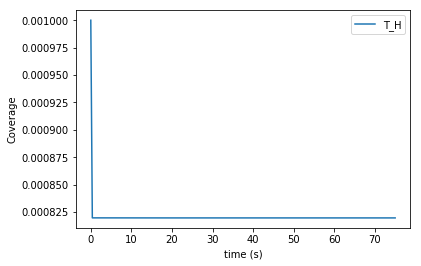

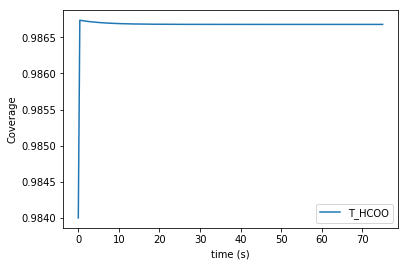

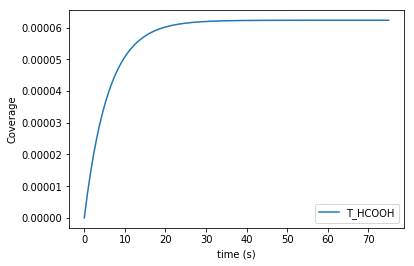

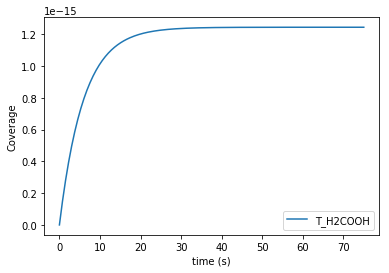

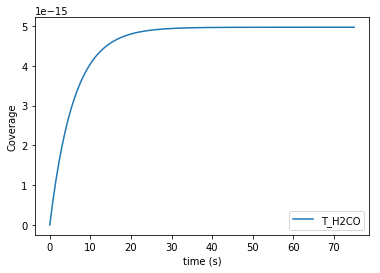

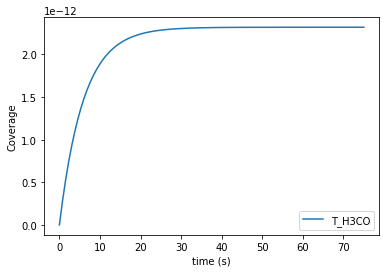

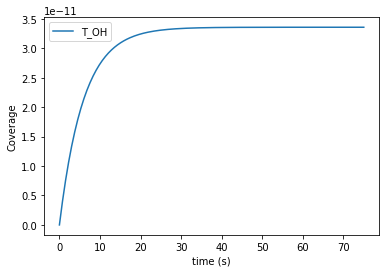

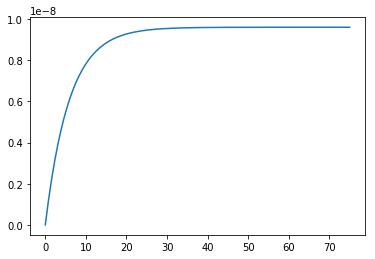

In [26]:
from scipy.optimize import fsolve

kb = 1.381e-23
h = 6.626e-34
R = 8.314
T = 450 #K
pH2 = 22.5 #bar
pCO2 = 7.5 #bar
pMETH = 0 #bar
pH2O = 0 #bar

def kd(dGi):
    return (kb*T/h)*np.exp(-dGi/R/T)

def func_k(G):
    
    Gts2, Gts3, Gts4, Gts5, Gts6, Gts7, Gts8, GHs, GHCOOs, GHCOOHs, \
    GH2COOHs, GH2COs, GH3COs, GOHs, GH3COH= G
    k1 = kd(2*GHs) 
    k2 = kd(Gts2 - GHs)
    k3 = kd(Gts3 - (GHCOOs + GHs))
    k4 = kd(Gts4 - (GHCOOHs + GHs))
    k5 = kd(Gts5 - GH2COOHs)
    k6 = kd(Gts6 - (GH2COs + GHs + GOHs))
    k7 = kd(Gts7 - (GH3COs + GHs + GOHs))
    k8 = kd(Gts8 - (GH3COH + GHs + GOHs))
    
    k_1 = kd(0) 
    k_2 = kd(Gts2 - GHCOOs)
    k_3 = kd(Gts3 - GHCOOHs)
    k_4 = kd(Gts4 - GH2COOHs)
    k_5 = kd(Gts5 - (GH2COs + GOHs))
    k_6 = kd(Gts6 - (GH3COs + GOHs))
    k_7 = kd(Gts7 - (GH3COH + GOHs))
    k_8 = kd(Gts8 - GH3COH)
    return np.array([k1,k2,k3,k4,k5,k6,k7,k8,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8])

def rsys(THETA, t, G):
    k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8 = func_k(G)
    T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = THETA
    
    T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
        
    # R1 : H2 + 2* --> 2H*
    r1 = k1 * pH2 * T_S**2
    r_1 = k_1 * T_H**2
    
    # R2: CO2 + H* --> HCOO*
    r2 = k2 * pCO2 * T_H
    r_2 = k_2 * T_HCOO 
    
    # R3: HCOO* + H* --> HCOOH* + *
    r3 = k3 * T_HCOO * T_H
    r_3 = k_3 * T_HCOOH * T_S
    
    # R4: HCOOH* + H* --> H2COOH + *
    r4 = k4 * T_HCOOH * T_H
    r_4 = k_4 * T_H2COOH * T_S
    
    # R5: H2COOH* + * --> H2CO* + OH*
    r5 = k5 * T_H2COOH * T_S
    r_5 = k_5 * T_H2CO * T_OH
    
    # R6: H2CO* + H* --> H3CO* + * 
    r6 = k6 * T_H2CO * T_H
    r_6 = k_6 * T_H3CO * T_S
    
    # R7: H3CO* + H* --> H3COH + 2*
    r7 = k7 * T_H3CO * T_H
    r_7 = k_7 * pMETH * T_S**2
    
    # R8: OH* + H* --> H20 + 2*
    r8 = k8 * T_OH * T_H
    r_8 = k_8 * pH2O * T_S**2
    
    #balance on H*
    z1 = (r1 - r_1) + (-r2 + r_2) + (-r3 + r_3) + (-r4 + r_4) + (-r6 + r_6) + (-r7 + r_7) + (-r8 + r_8)
    
    #balance on HCOO*
    z2 = (r2 - r_2) + (-r3 + r_3)
    
    #balance on HCOOH*
    z3 = (r3 - r_3) + (-r4 + r_4)
    
    #balance on H2COOH*
    z4 = (r4 - r_4) + (-r5 + r_5)
    
    #balance on H2CO*
    z5 = (r5 - r_5) + (-r6 + r_6)
    
    #balance on H3CO*
    z6 = (r6 - r_6) + (-r7 + r_7)
    
    #balance on OH*
    z7 = (r5 - r_5) + (-r8 + r_8)
    
#     z8 = 1 - z1 - z2 - z3 - z4 - z5 - z6 - z7 
    
    return np.array([z1, z2, z3, z4, z5, z6, z7])

#   Gts2 Gts3  Gts4  Gts5  Gts6  Gts7  Gts8  GHs   GHCOOs GHCOOHs GH2COOHs  GH2COs  GH3COs GOHs, GH3COH
G = np.array([1.01, 1.41, 1.73, 1.33, 1.53, 1.35, 1.25, 0.16, -0.03, 0.39,   0.97,    0.90,   0.49,  0.16,  0.29]) # made a set using the excel sheet
G = G*100000
# [T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S] = \

k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8 = func_k(G)
print(k1/k_1)

tspan = np.linspace(0,75,200)

# [T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S]
Th = odeint(rsys, [0.001, 0.984, 0.0000, 0.0000, 0.0000, 0.0000, 0.00000], tspan, args = ((G,)))
# print(sum([0.001, 0.984, 0.0000, 0.0000, 0.0000, 0.0000, 0.00000]))
# print(T.T[:,-1])
# print(sum([T.T[:,-1]][0]))
# r = k4 * T_HCOO * T_H

# for i in range(len(T[1,:])):
#     print(i)

T_list = ['T_H', 'T_HCOO', 'T_HCOOH', 'T_H2COOH', 'T_H2CO', 'T_H3CO', 'T_OH', 'T_S']

for i in range(len(Th[1,:])):
    plt.plot(tspan, Th[:,i],label = T_list[i])
    plt.xlabel('time (s)')
    plt.ylabel('Coverage')
    plt.legend()
    plt.show()

r = k7*Th[:,0]*Th[:,5]
plt.plot(tspan, r)     

In [27]:
%store Th

Stored 'Th' (ndarray)


In [3]:
kb = 1.381e-23
h = 6.626e-34
R = 8.314
T = 450 #K
pH2 = 22.5 #bar
pCO2 = 7.5 #bar
pMETH = 0 #bar
pH2O = 0 #bar


def kd(dGi):
    return (kb*T/h)*np.exp(-dGi/R/T)

def solver(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8):
 
    def inside(THETA, t, k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8):
        T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = THETA
    
        T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH

        # R1 : H2 + 2* --> 2H*
        r1 = k1 * pH2 * T_S**2
        r_1 = k_1 * T_H**2

        # R2: CO2 + H* --> HCOO*
        r2 = k2 * pCO2 * T_H
        r_2 = k_2 * T_HCOO 

        # R3: HCOO* + H* --> HCOOH* + *
        r3 = k3 * T_HCOO * T_H
        r_3 = k_3 * T_HCOOH * T_S

        # R4: HCOOH* + H* --> H2COOH + *
        r4 = k4 * T_HCOOH * T_H
        r_4 = k_4 * T_H2COOH * T_S

        # R5: H2COOH* + * --> H2CO* + OH*
        r5 = k5 * T_H2COOH * T_S
        r_5 = k_5 * T_H2CO * T_OH

        # R6: H2CO* + H* --> H3CO* + * 
        r6 = k6 * T_H2CO * T_H
        r_6 = k_6 * T_H3CO * T_S

        # R7: H3CO* + H* --> H3COH + 2*
        r7 = k7 * T_H3CO * T_H
        r_7 = k_7 * pMETH * T_S**2

        # R8: OH* + H* --> H20 + 2*
        r8 = k8 * T_OH * T_H
        r_8 = k_8 * pH2O * T_S**2

        #balance on H*
        z1 = (r1 - r_1) + (-r2 + r_2) + (-r3 + r_3) + (-r4 + r_4) + (-r6 + r_6) + (-r7 + r_7) + (-r8 + r_8)

        #balance on HCOO*
        z2 = (r2 - r_2) + (-r3 + r_3)

        #balance on HCOOH*
        z3 = (r3 - r_3) + (-r4 + r_4)

        #balance on H2COOH*
        z4 = (r4 - r_4) + (-r5 + r_5)

        #balance on H2CO*
        z5 = (r5 - r_5) + (-r6 + r_6)

        #balance on H3CO*
        z6 = (r6 - r_6) + (-r7 + r_7)

        #balance on OH*
        z7 = (r5 - r_5) + (-r8 + r_8)

        return np.array([z1, z2, z3, z4, z5, z6, z7])
    print('A')

    tspan = Tspan
    Theta = odeint(inside, [0.05, 0.9, 0.0000, 0.0000, 0.0000, 0.0000, 0.00000], tspan, tuple((k1,k2,k3,k4,k5,k6,k7,k8,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,)))
    print('A')
    return Theta

def outside(G):
    Gts2, Gts3, Gts4, Gts5, Gts6, Gts7, Gts8, GHs, GHCOOs, GHCOOHs, \
    GH2COOHs, GH2COs, GH3COs, GOHs, GH3COH = G
    
    k1 = kd(2*GHs) 
    k2 = kd(Gts2 - GHs)
    k3 = kd(Gts3 - (GHCOOs + GHs))
    k4 = kd(Gts4 - (GHCOOHs + GHs))
    k5 = kd(Gts5 - GH2COOHs)
    k6 = kd(Gts6 - (GH2COs + GHs + GOHs))
    k7 = kd(Gts7 - (GH3COs + GHs + GOHs))
    k8 = kd(Gts8 - (GH3COH + GHs + GOHs))
    
    k_1 = kd(0) 
    k_2 = kd(Gts2 - GHCOOs)
    k_3 = kd(Gts3 - GHCOOHs)
    k_4 = kd(Gts4 - GH2COOHs)
    k_5 = kd(Gts5 - (GH2COs + GOHs))
    k_6 = kd(Gts6 - (GH3COs + GOHs))
    k_7 = kd(Gts7 - (GH3COH + GOHs))
    k_8 = kd(Gts8 - GH3COH)
    
    Theta = solver(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8)
    print(T)
    T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = Theta[:,0],Theta[:,1],Theta[:,2],Theta[:,3],Theta[:,4],Theta[:,5],Theta[:,6]
    T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
    r = k4 * T_HCOO * T_H
    return r, T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH

G0 = np.array([1.01, 1.41, 1.73, 1.33, 1.53, 1.35, 1.25, 0.16, -0.03, 0.39,   0.97,    0.90,   0.49,  0.16,  0.29]) # made a set using the excel sheet 
G0 = 100000*G0
print(G0)
char = ['Gts2', 'Gts3', 'Gts4', 'Gts5', 'Gts6', 'Gts7', 'Gts8', 'GHs', 'GHCOOs', 'GHCOOHs', \
    'GH2COOHs', 'GH2COs', 'GH3COs', 'GOHs', 'GH3COH']

Tspan = np.linspace(0,1e-2)

r, T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = outside(G0)
T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
Theta = np.array([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S])
# sum([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S])

print(Theta[:,-1])
print('sum:',sum(Theta[:,-1]))


for i in range(len(Theta)):
    plt.plot(tspan, Theta[i])
    plt.show()
# drdg = grad(outside)
# r = outside(G0)
# print(f'Rate = {r}')
# X_p = -np.array(drdg(G0))*R*T/r
# i = 0
# for x in X_p:
#     print(f'The DRC for {char[i]} is {x:1.5f}')
#     i +=1

[101000. 141000. 173000. 133000. 153000. 135000. 125000.  16000.  -3000.
  39000.  97000.  90000.  49000.  16000.  29000.]
A
A
450
[8.33064587e-04 9.86522675e-01 2.12683288e-07 4.24481376e-18
 1.69591953e-17 7.82209592e-15 9.50331556e-14 1.26440480e-02]
sum: 0.9999999999999999


NameError: name 'tspan' is not defined

In [294]:
kb = 1.381e-23
h = 6.626e-34
R = 8.314
T = 450 #K
pH2 = 22.5 #bar
pCO2 = 7.5 #bar
pMETH = 0 #bar
pH2O = 0 #bar


def kd(dGi):
    return (kb*T/h)*np.exp(-dGi/R/T)

def solver(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8):
 
    def inside(THETA, t, k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8):
        T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = THETA
    
        T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH

        # R1 : H2 + 2* --> 2H*
        r1 = k1 * pH2 * T_S**2
        r_1 = k_1 * T_H**2

        # R2: CO2 + H* --> HCOO*
        r2 = k2 * pCO2 * T_H
        r_2 = k_2 * T_HCOO 

        # R3: HCOO* + H* --> HCOOH* + *
        r3 = k3 * T_HCOO * T_H
        r_3 = k_3 * T_HCOOH * T_S

        # R4: HCOOH* + H* --> H2COOH + *
        r4 = k4 * T_HCOOH * T_H
        r_4 = k_4 * T_H2COOH * T_S

        # R5: H2COOH* + * --> H2CO* + OH*
        r5 = k5 * T_H2COOH * T_S
        r_5 = k_5 * T_H2CO * T_OH

        # R6: H2CO* + H* --> H3CO* + * 
        r6 = k6 * T_H2CO * T_H
        r_6 = k_6 * T_H3CO * T_S

        # R7: H3CO* + H* --> H3COH + 2*
        r7 = k7 * T_H3CO * T_H
        r_7 = k_7 * pMETH * T_S**2

        # R8: OH* + H* --> H20 + 2*
        r8 = k8 * T_OH * T_H
        r_8 = k_8 * pH2O * T_S**2

        #balance on H*
        z1 = (r1 - r_1) + (-r2 + r_2) + (-r3 + r_3) + (-r4 + r_4) + (-r6 + r_6) + (-r7 + r_7) + (-r8 + r_8)

        #balance on HCOO*
        z2 = (r2 - r_2) + (-r3 + r_3)

        #balance on HCOOH*
        z3 = (r3 - r_3) + (-r4 + r_4)

        #balance on H2COOH*
        z4 = (r4 - r_4) + (-r5 + r_5)

        #balance on H2CO*
        z5 = (r5 - r_5) + (-r6 + r_6)

        #balance on H3CO*
        z6 = (r6 - r_6) + (-r7 + r_7)

        #balance on OH*
        z7 = (r5 - r_5) + (-r8 + r_8)

        return np.array([z1, z2, z3, z4, z5, z6, z7])

    tspan = Tspan
    Theta = odeint(inside, [0.05, 0.9, 0.0000, 0.0000, 0.0000, 0.0000, 0.00000], tspan, tuple((k1,k2,k3,k4,k5,k6,k7,k8,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,)))

    return Theta

def outside(G,i):
    Gts2, Gts3, Gts4, Gts5, Gts6, Gts7, Gts8, GHs, GHCOOs, GHCOOHs, \
    GH2COOHs, GH2COs, GH3COs, GOHs, GH3COH = G
    
    k1 = kd(2*GHs) 
    k2 = kd(Gts2 - GHs)
    k3 = kd(Gts3 - (GHCOOs + GHs))
    k4 = kd(Gts4 - (GHCOOHs + GHs))
    k5 = kd(Gts5 - GH2COOHs)
    k6 = kd(Gts6 - (GH2COs + GHs + GOHs))
    k7 = kd(Gts7 - (GH3COs + GHs + GOHs))
    k8 = kd(Gts8 - (GH3COH + GHs + GOHs))
    
    k_1 = kd(0) 
    k_2 = kd(Gts2 - GHCOOs)
    k_3 = kd(Gts3 - GHCOOHs)
    k_4 = kd(Gts4 - GH2COOHs)
    k_5 = kd(Gts5 - (GH2COs + GOHs))
    k_6 = kd(Gts6 - (GH3COs + GOHs))
    k_7 = kd(Gts7 - (GH3COH + GOHs))
    k_8 = kd(Gts8 - GH3COH)
    
    Theta = solver(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8)
    T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = Theta[i,0],Theta[i,1],Theta[i,2],Theta[i,3],Theta[i,4],Theta[i,5],Theta[i,6]
    T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
    r = k4 * T_HCOO * T_H
    return r

G0 = np.array([1.01, 1.41, 1.73, 1.33, 1.53, 1.35, 1.25, 0.16, -0.03, 0.39,   0.97,    0.90,   0.49,  0.16,  0.29]) # made a set using the excel sheet 
G0 = 100000*G0
print(G0)
char = ['Gts2', 'Gts3', 'Gts4', 'Gts5', 'Gts6', 'Gts7', 'Gts8', 'GHs', 'GHCOOs', 'GHCOOHs', \
    'GH2COOHs', 'GH2COs', 'GH3COs', 'GOHs', 'GH3COH']

Tspan = np.linspace(0,1e-2)

# T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = outside(G0)
# T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
# Theta = np.array([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S])
# sum([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S])

drdg = elementwise_grad(outside)
r = []
xrc = []
for i in range(len(Tspan)):
    r.append(outside(G0,i))
    X_p = -np.array(drdg(G0,i))*R*T
    xrc.append(X_p/r[i])


[101000. 141000. 173000. 133000. 153000. 135000. 125000.  16000.  -3000.
  39000.  97000.  90000.  49000.  16000.  29000.]


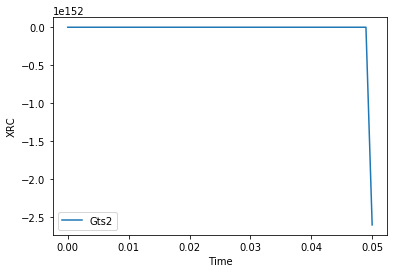

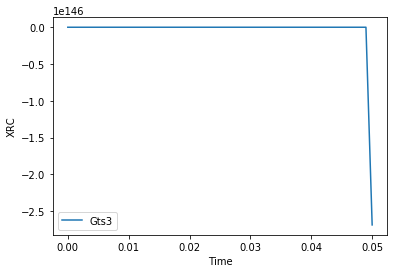

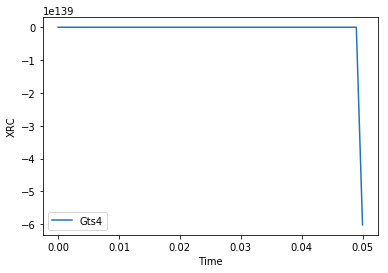

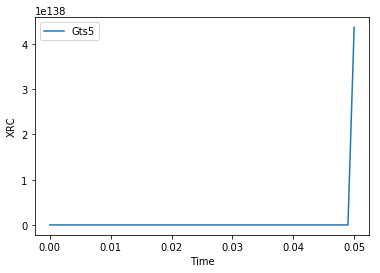

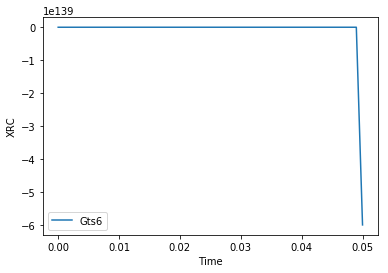

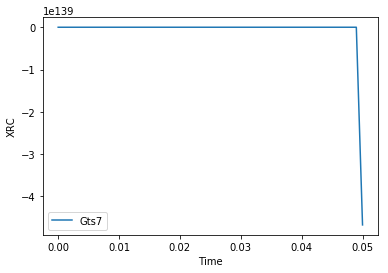

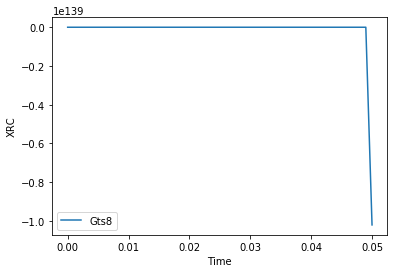

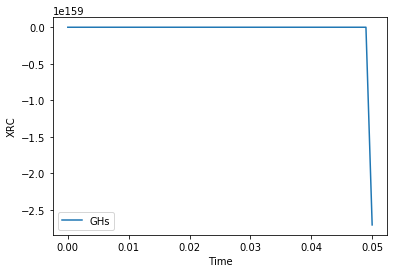

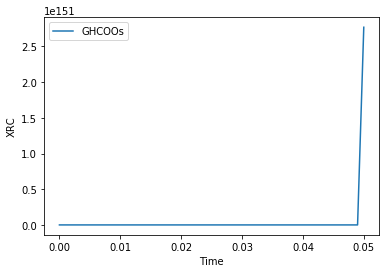

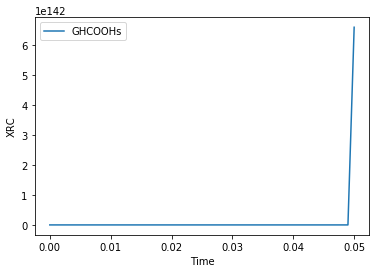

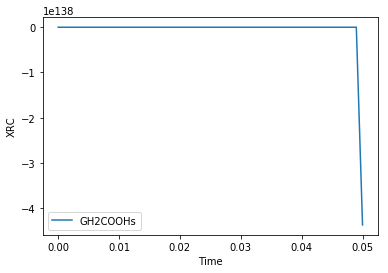

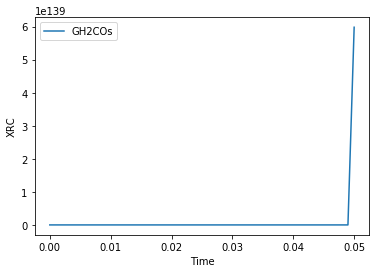

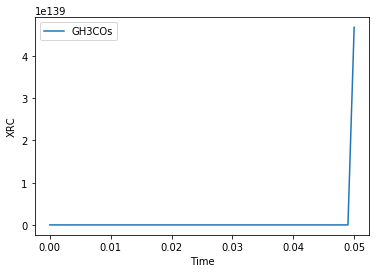

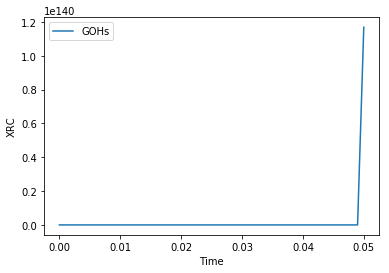

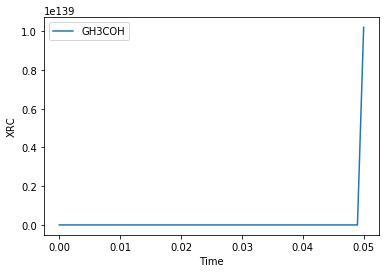

In [301]:
# plt.plot(tspan, r)
xrc = np.array(xrc)
for i in range(len(char)):
    plt.plot(tspan,xrc[:,i], label = char[i])
    plt.legend()
    plt.ylabel('XRC')
    plt.xlabel('Time')
    plt.show()

In [305]:
print(xrc[:,3])

[-0.00000000e+000  9.64012182e-002  2.39369094e+003  1.68425294e+001
 -2.47041095e+010  2.10140124e+001 -1.36993673e+011  1.82572156e+005
 -4.42701486e+016  2.41099175e+023  8.15674745e+008  5.42385562e+022
  2.31292634e+041 -1.20212179e+021  1.08599600e+033 -1.92198929e+025
  7.72358291e+031 -1.45669151e+041  1.82646704e+037  4.75693257e+039
  4.98282437e+054 -4.85103480e+046  1.08100716e+059  1.08099774e+064
 -9.95805084e+067 -6.01543519e+043 -5.00505306e+082 -1.92100684e+063
 -1.02438423e+063  2.79418761e+057 -7.57839762e+036  6.51904610e+061
  3.61495265e+034 -7.10621808e+083 -4.02726242e+063 -2.00705062e+058
  2.32527220e+102  7.23802130e+073 -4.92767411e+101  2.20913767e+105
  5.33724746e+052  6.23581607e+119  2.13424900e+097  8.29271140e+119
 -3.67389428e+087  5.76122447e+108  3.40934022e+101 -2.19459369e+082
 -1.55624837e+059  4.37232318e+138]


### FInitie Difference 

[101000. 141000. 173000. 133000. 153000. 135000. 125000.  16000.  -3000.
  39000.  97000.  90000.  49000.  16000.  29000.]
A
A
450
[8.33064587e-04 9.86522675e-01 2.12683288e-07 4.24481376e-18
 1.69591953e-17 7.82209592e-15 9.50331556e-14 1.26440480e-02]
sum: 0.9999999999999999


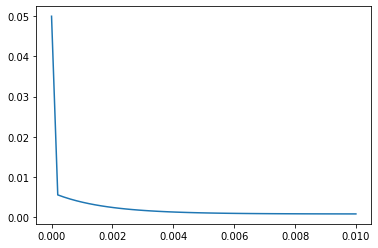

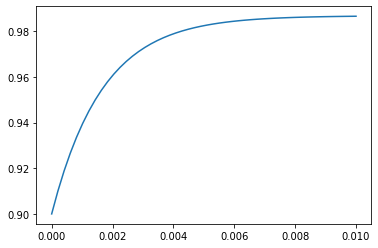

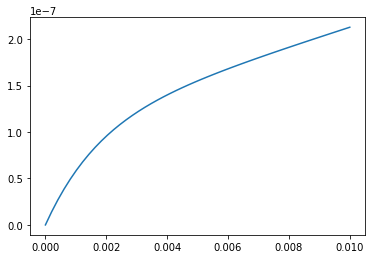

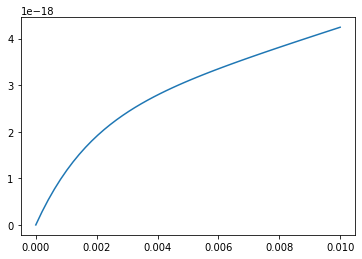

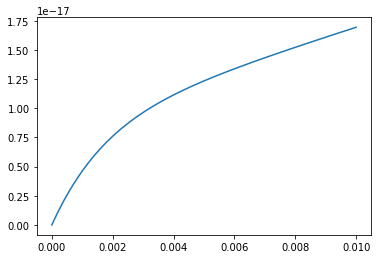

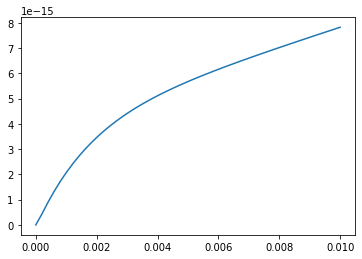

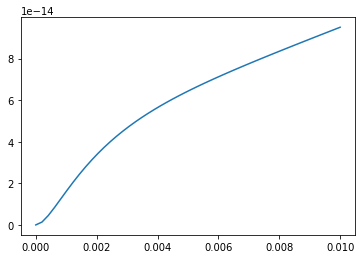

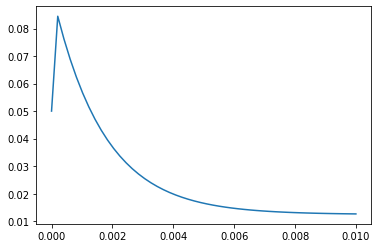

In [5]:
# First calculating the transient theta vector

kb = 1.381e-23
h = 6.626e-34
R = 8.314
T = 450 #K
pH2 = 22.5 #bar
pCO2 = 7.5 #bar
pMETH = 0 #bar
pH2O = 0 #bar

# tspan = np.linspace(0,75,200)

def kd(dGi):
    return (kb*T/h)*np.exp(-dGi/R/T)

def solver(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8):
 
    def inside(THETA, t, k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8):
        T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = THETA
    
        T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH

        # R1 : H2 + 2* --> 2H*
        r1 = k1 * pH2 * T_S**2
        r_1 = k_1 * T_H**2

        # R2: CO2 + H* --> HCOO*
        r2 = k2 * pCO2 * T_H
        r_2 = k_2 * T_HCOO 

        # R3: HCOO* + H* --> HCOOH* + *
        r3 = k3 * T_HCOO * T_H
        r_3 = k_3 * T_HCOOH * T_S

        # R4: HCOOH* + H* --> H2COOH + *
        r4 = k4 * T_HCOOH * T_H
        r_4 = k_4 * T_H2COOH * T_S

        # R5: H2COOH* + * --> H2CO* + OH*
        r5 = k5 * T_H2COOH * T_S
        r_5 = k_5 * T_H2CO * T_OH

        # R6: H2CO* + H* --> H3CO* + * 
        r6 = k6 * T_H2CO * T_H
        r_6 = k_6 * T_H3CO * T_S

        # R7: H3CO* + H* --> H3COH + 2*
        r7 = k7 * T_H3CO * T_H
        r_7 = k_7 * pMETH * T_S**2

        # R8: OH* + H* --> H20 + 2*
        r8 = k8 * T_OH * T_H
        r_8 = k_8 * pH2O * T_S**2

        #balance on H*
        z1 = (r1 - r_1) + (-r2 + r_2) + (-r3 + r_3) + (-r4 + r_4) + (-r6 + r_6) + (-r7 + r_7) + (-r8 + r_8)

        #balance on HCOO*
        z2 = (r2 - r_2) + (-r3 + r_3)

        #balance on HCOOH*
        z3 = (r3 - r_3) + (-r4 + r_4)

        #balance on H2COOH*
        z4 = (r4 - r_4) + (-r5 + r_5)

        #balance on H2CO*
        z5 = (r5 - r_5) + (-r6 + r_6)

        #balance on H3CO*
        z6 = (r6 - r_6) + (-r7 + r_7)

        #balance on OH*
        z7 = (r5 - r_5) + (-r8 + r_8)

        return np.array([z1, z2, z3, z4, z5, z6, z7])
    print('A')

    tspan = Tspan
    Theta = odeint(inside, [0.05, 0.9, 0.0000, 0.0000, 0.0000, 0.0000, 0.00000], tspan, tuple((k1,k2,k3,k4,k5,k6,k7,k8,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,)))
    print('A')
    return Theta

def outside(G):
    Gts2, Gts3, Gts4, Gts5, Gts6, Gts7, Gts8, GHs, GHCOOs, GHCOOHs, \
    GH2COOHs, GH2COs, GH3COs, GOHs, GH3COH = G
    
    k1 = kd(2*GHs) 
    k2 = kd(Gts2 - GHs)
    k3 = kd(Gts3 - (GHCOOs + GHs))
    k4 = kd(Gts4 - (GHCOOHs + GHs))
    k5 = kd(Gts5 - GH2COOHs)
    k6 = kd(Gts6 - (GH2COs + GHs + GOHs))
    k7 = kd(Gts7 - (GH3COs + GHs + GOHs))
    k8 = kd(Gts8 - (GH3COH + GHs + GOHs))
    
    k_1 = kd(0) 
    k_2 = kd(Gts2 - GHCOOs)
    k_3 = kd(Gts3 - GHCOOHs)
    k_4 = kd(Gts4 - GH2COOHs)
    k_5 = kd(Gts5 - (GH2COs + GOHs))
    k_6 = kd(Gts6 - (GH3COs + GOHs))
    k_7 = kd(Gts7 - (GH3COH + GOHs))
    k_8 = kd(Gts8 - GH3COH)
    
    Theta = solver(k1, k2, k3, k4, k5, k6, k7, k8, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8)
    print(T)
    T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = Theta[:,0],Theta[:,1],Theta[:,2],Theta[:,3],Theta[:,4],Theta[:,5],Theta[:,6]
    T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
    r = k4 * T_HCOO * T_H
    return r, T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH

G0 = np.array([1.01, 1.41, 1.73, 1.33, 1.53, 1.35, 1.25, 0.16, -0.03, 0.39,   0.97,    0.90,   0.49,  0.16,  0.29]) # made a set using the excel sheet 
G0 = 100000*G0
print(G0)
char = ['Gts2', 'Gts3', 'Gts4', 'Gts5', 'Gts6', 'Gts7', 'Gts8', 'GHs', 'GHCOOs', 'GHCOOHs', \
    'GH2COOHs', 'GH2COs', 'GH3COs', 'GOHs', 'GH3COH']

Tspan = np.linspace(0,1e-2)

r, T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH = outside(G0)
T_S = 1 - T_H - T_HCOO - T_HCOOH - T_H2COOH - T_H2CO - T_H3CO - T_OH
Theta = np.array([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S])
# sum([T_H, T_HCOO, T_HCOOH, T_H2COOH, T_H2CO, T_H3CO, T_OH, T_S])

print(Theta[:,-1])
print('sum:',sum(Theta[:,-1]))


for i in range(len(Theta)):
    plt.plot(Tspan, Theta[i])
    plt.show()
# drdg = grad(outside)
# r = outside(G0)
# print(f'Rate = {r}')
# X_p = -np.array(drdg(G0))*R*T/r
# i = 0
# for x in X_p:
#     print(f'The DRC for {char[i]} is {x:1.5f}')
#     i +=1

In [ ]:
## Finite Differences: 
# First calculate the values of time dependent theta for G - 10 and then calculate it for G + 10.


Again, with the conditions that were provided by Prof. Campbell, it seems like the adsorption happens very quickly (around 10^-12 seconds). So, it could be that Prof. Campbell has not made these systems taking transient conditions in mind.

In [6]:
from scipy.optimize import fsolve

kb = 1.381e-23
h = 6.626e-34
R = 8.314

def rsys(theta,t, G):
    "Steady state mole balance, returns 0 at the steady state coverages."
    thetaa, thetab, thetaab = theta

    k1, k_1, k2, k_2, k3, k_3, k4, k_4 = fk(G)

    thetastar = 1 - thetaa - thetab - thetaab
    
    # balance on A*
    z1 = (k1 * pa * thetastar - k_1 * thetaa
          - k3 * thetaa * thetab + k_3 * thetaab * thetastar)
    # balance on B*
    z2 = (k2 * pb * thetastar - k_2 * thetab
          - k3 * thetaa * thetab + k_3 * thetaab * thetastar)
    # balance on AB*
    z3 = (k3 * thetaa * thetab - k_3 * thetaab * thetastar
          - k4 * thetaab + k_4 * pab * thetastar)
    # site balance
    
    return np.array([z1, z2, z3])

T = 300.0

# pressures of each species, consistent with the earlier limiting conditions.
pa = 20
pb = 0.01
pab = 0.0

#   Gts1, Gts2, Gts3, Gts4, Gas,       Gbs,   Gabs
# G = (0.1, 0.1, 1.0, 0.0, -20000.0, -0.01, -20000.0)
G = [1.00000000e-01,  2.00001000e+04, 1.00017100e+04, -4.00016000e+04, -2.00009100e+04, -9.00003324e-01, -4.00017100]
k1, k_1, k2, k_2, k3, k_3, k4, k_4 = fk(G)

#for k in (k1, k_1, k2, k_2, k3, k_3, k4, k_4):
#    print(f'{k:1.3e}')

# Solve for the thetas

tspan = np.linspace(0,1e-8)
t_initial = [0.98, 0.01, 0.01]
T = odeint(rsys, t_initial, tspan, args = ((G,)))
# Make sure these are all positive.

plt.plot(tspan,T[:,0])
plt.show()
plt.plot(tspan, T[:,1])
plt.plot(tspan, T[:,2])

[Thetaa, Thetab, Thetaab] = [T[:,0], T[:,1], T[:,2]]
print(Thetaa)
Thetas = 1 - Thetaa - Thetab - Thetaab
print(Thetas)

# Now we can compute the rate from any one of these expressions
r = k2 * pb * thetas - k_2 * thetab

NameError: name 'fk' is not defined